# Descrição do Projeto  

Este projeto visa analisar perfis de clientes da empresa Model Fitness, a fim de criar uma estratégia de retenção de clientes.

Será realizado:  
- Predição de rotabilidade (para o mês seguinte) para cada cliente;  
- Elaboração de retratos de usuários típicos: grupos mais marcantes e suas principais características;  
- Analise os fatores que mais impactam a rotatividade;  
- Conclusões e recomendações sobre como melhorar o serviço de clientes:  
    - Indentificação de grupos alvo;  
    - Sugestão de medidas para diminuir a rotatividade;

### Importando as biblitecas

In [67]:
# Importing the libraries
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans

# Setting a default color palette for the plots
my_palette = ['#768948', '#607744', '#34623f', '#34623f', '#1e2f23']
sns.set_palette(sns.color_palette(my_palette))

In [68]:
# Importing the data from a CSV file
df_churn = pd.read_csv(Path('datasets/gym_churn_us.csv'))

### EDA

In [69]:
# Displaying the first few rows
df_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [70]:
# Getting general information about the dataset
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [71]:
# Checking some statistics of the data
df_churn.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [72]:
# Grouping the data by the 'Churn' column and calculating the mean of the features
grouped_data = df_churn.groupby('Churn', as_index=False).mean()
grouped_data

,Churn,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


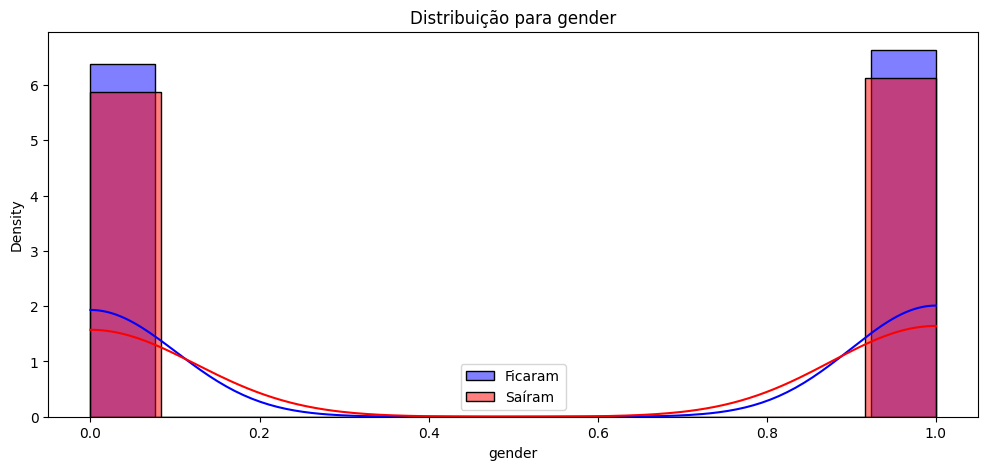

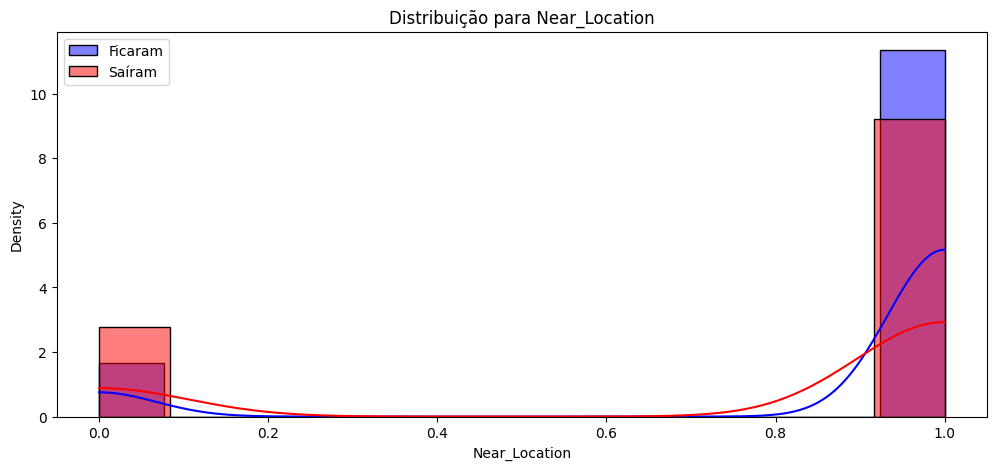

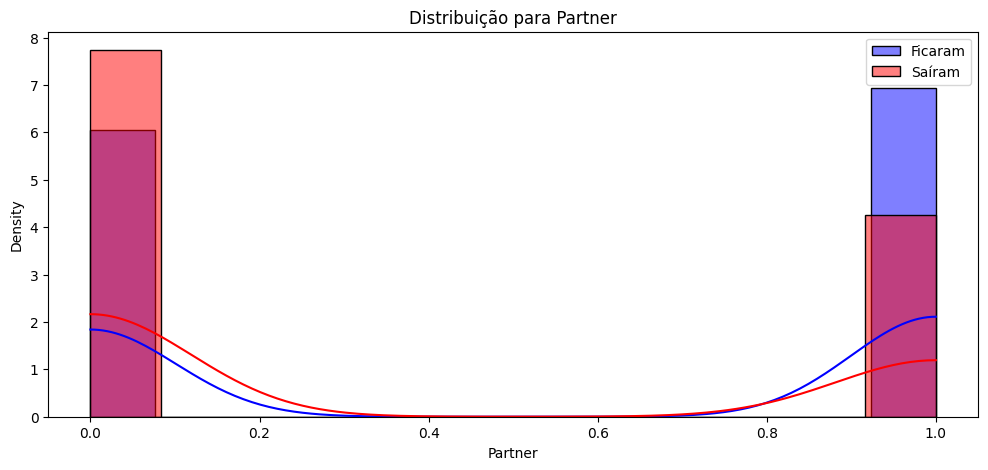

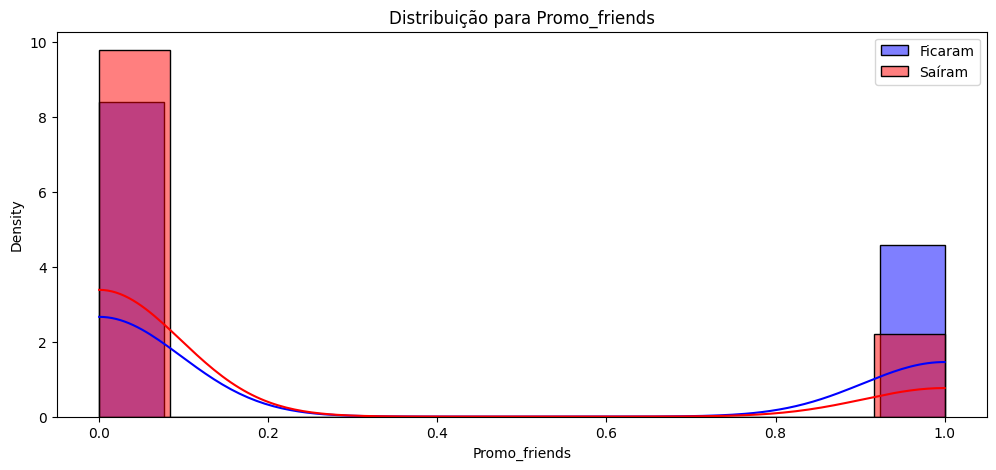

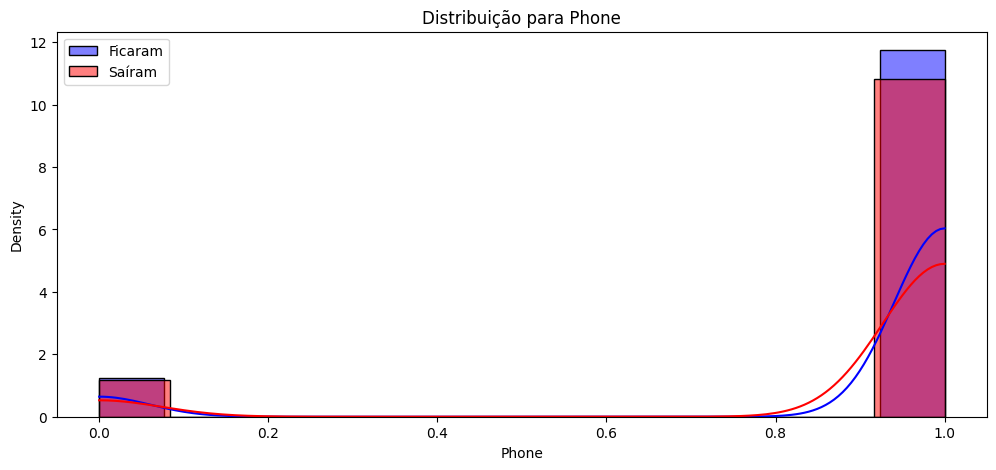

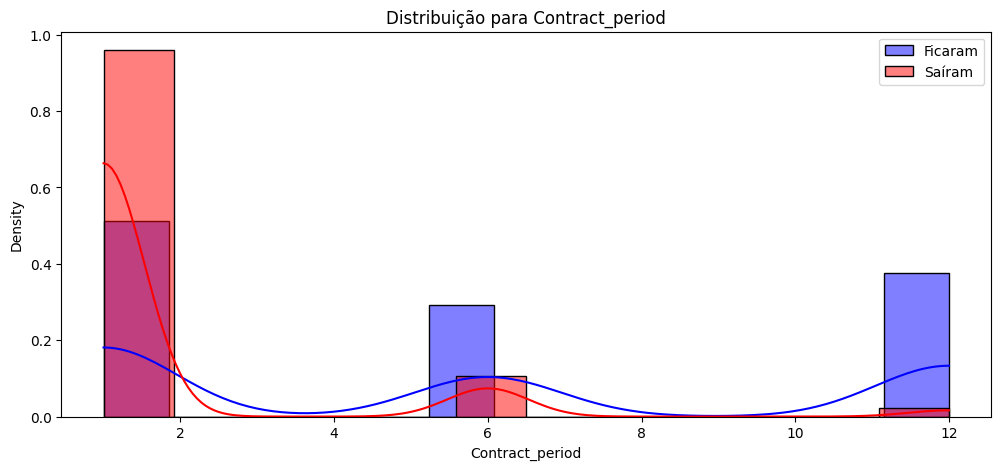

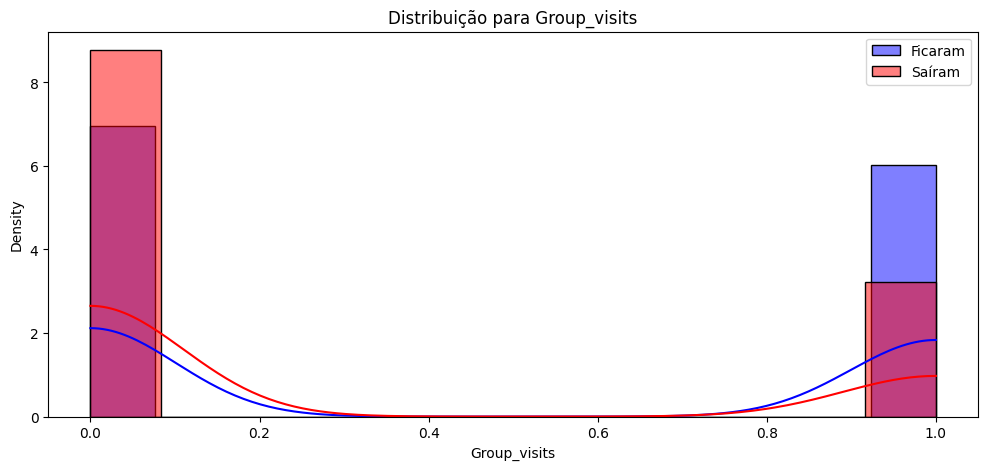

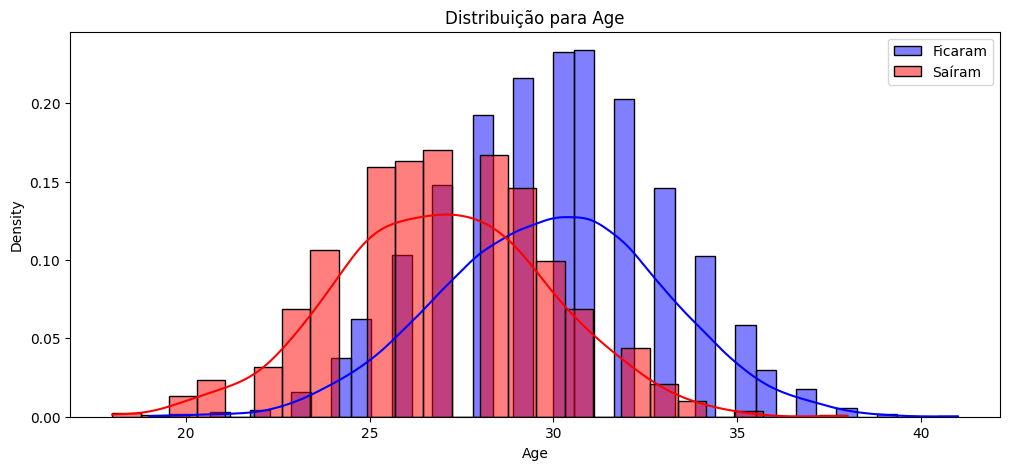

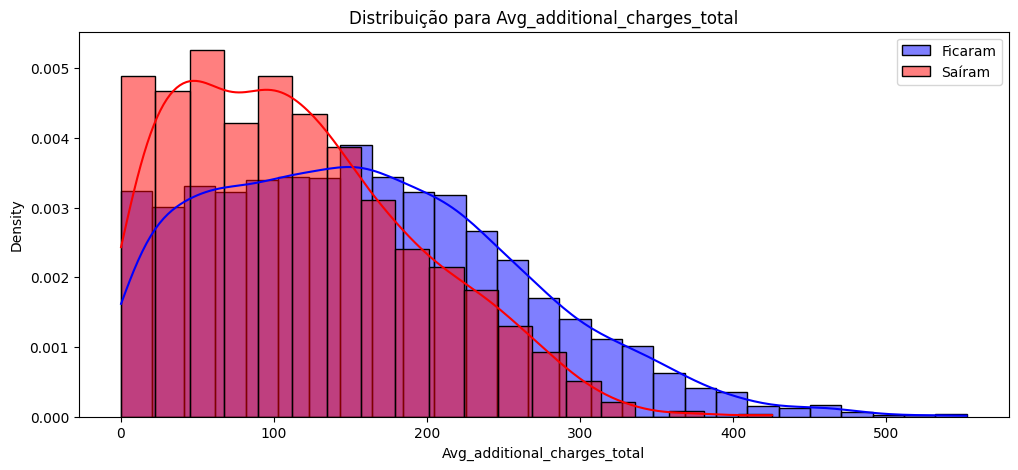

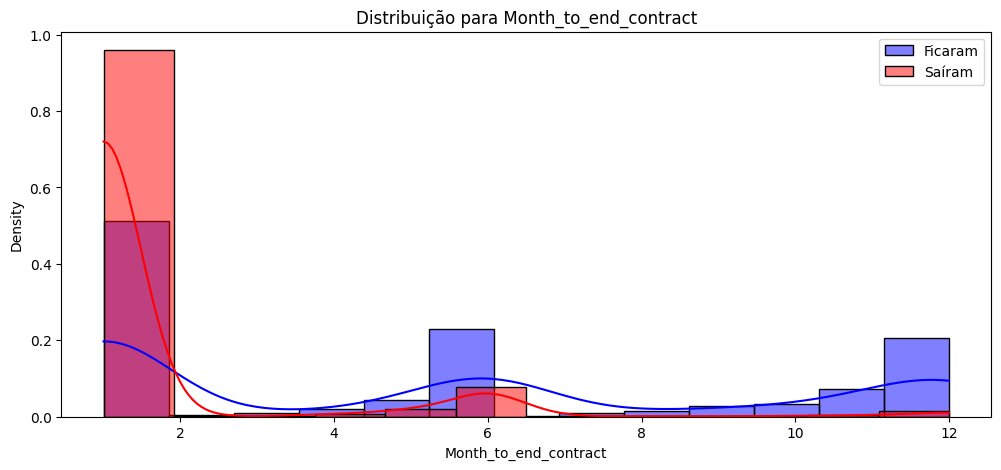

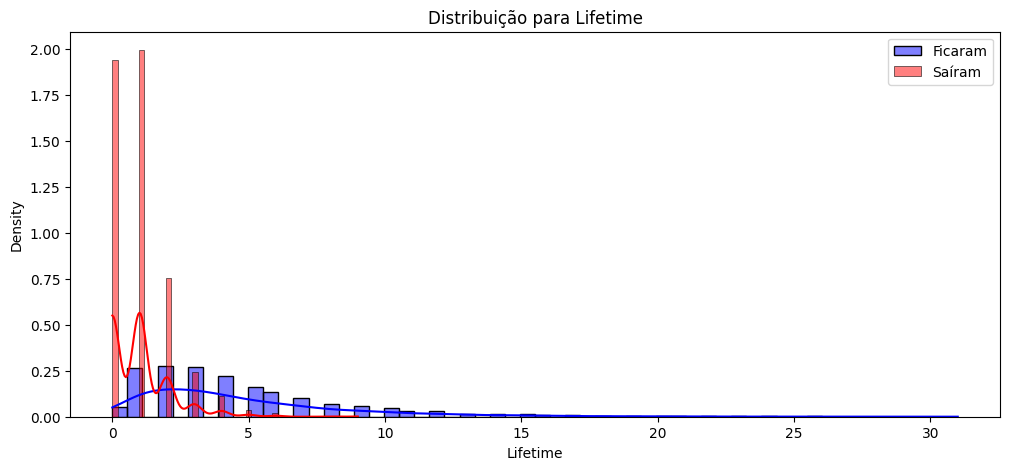

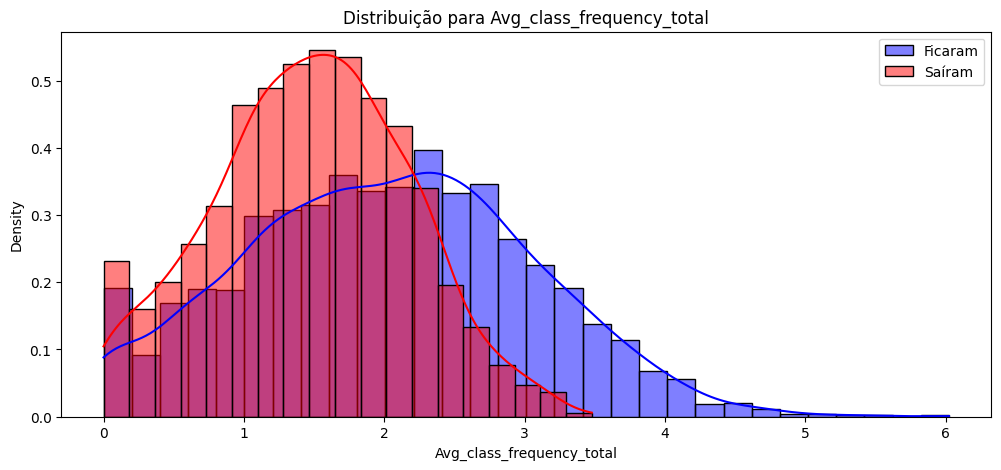

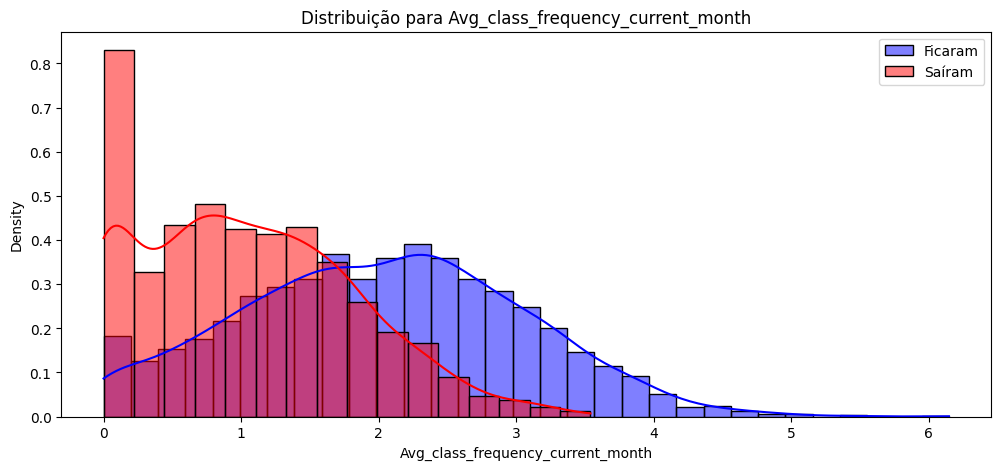

In [73]:
# Splitting the data into non-churned and churned
df_stayed = df_churn[df_churn['Churn']==0]
df_left = df_churn[df_churn['Churn']==1]

# Creating distributions for the numerical features
numerical_features = (df_churn.columns).drop('Churn')

for feature in numerical_features:
    plt.figure(figsize=(12, 5))
    sns.histplot(df_stayed[feature], kde=True, color='blue', label='Ficaram', stat='density')
    sns.histplot(df_left[feature], kde=True, color='red', label='Saíram', stat='density')
    plt.title(f'Distribuição para {feature}')
    plt.legend()
    plt.show()

<Axes: >

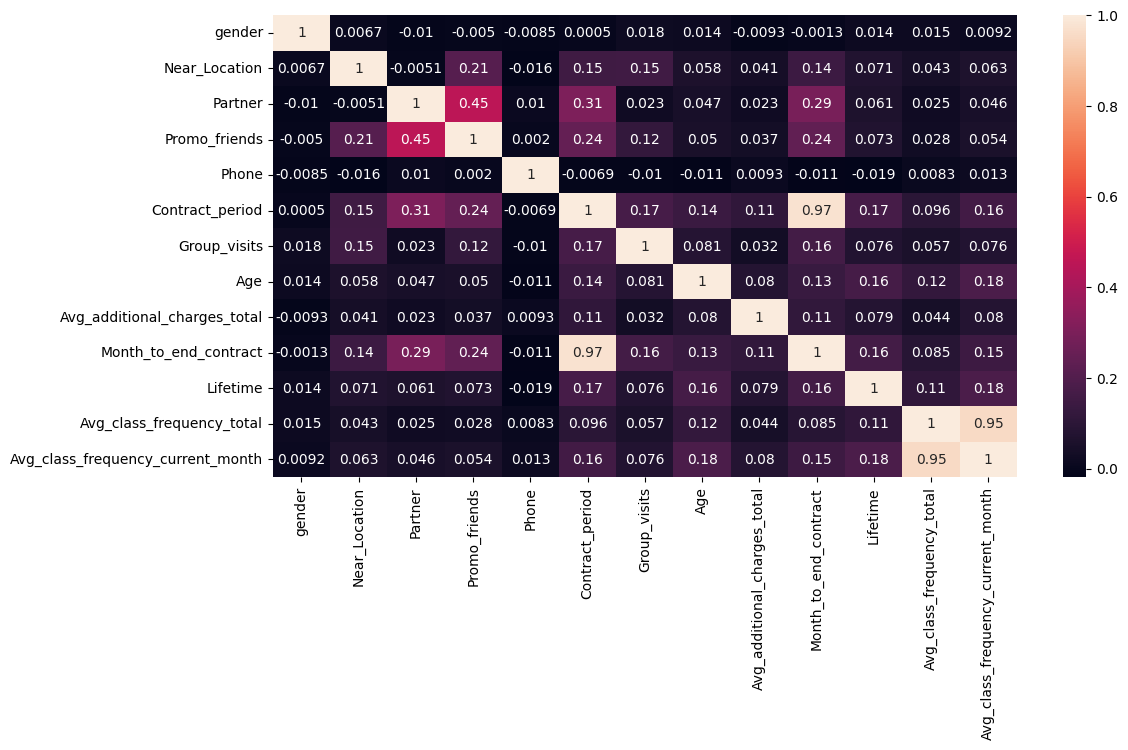

In [74]:
# Calculating the correlation matrix for numerical features
cm = df_churn.drop(columns='Churn').corr()
plt.figure(figsize=(12,6))
sns.heatmap(cm, annot=True)

Nesta primeira parte do projeto exploramos o dataframe para identificar pontos de melhoria nos dados. Não encontramos colunas com valores ausentes, e todas as características já estão em formato numérico, não necessitando de ajustes em relação a isso. Além disso, separamos o dataframe entre os dados de clientes que cancelaram e aqueles que ficaram para visualizar similaridades nas distribuições das variáveis.

Nesta segunda etapa já podemos visualizar algumas características que possuem uma diferença nas distribuições, como por exemplo o período de contrato do cliente, mas vamos avaliar melhor em seguida.

Por fim, geramos a matriz de correlação para observar as características com forte correlação mútua.

### Construindo o Modelo de Previsão do Churn

In [75]:
# Separating the features (X) and the target variable (y)
X = df_churn.drop(columns=['Churn'])
y = df_churn['Churn']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [76]:
# Listing the models to be applied
models = [
    (LogisticRegression(random_state=1, max_iter=1000), 'Regressão Logística'),
    (RandomForestClassifier(n_estimators=100, random_state=1), 'Floresta Aleatória')
]

# Function to train and evaluate a model
def make_predict(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
   
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    return accuracy, precision, recall

In [77]:
# Evaluate and display results for each model
for model, model_name in models:
    accuracy, precision, recall = make_predict(
        model, X_train, y_train, X_test, y_test)
    print(f"Modelo: {model_name}")
    print(f"Acurácia: {accuracy:.2f}")
    print(f"Precisão: {precision:.2f}")
    print(f"Sensibilidade: {recall:.2f}")
    print("\n")

Modelo: Regressão Logística
Acurácia: 0.93
Precisão: 0.89
Sensibilidade: 0.86


Modelo: Floresta Aleatória
Acurácia: 0.92
Precisão: 0.87
Sensibilidade: 0.85




Após treinar e avaliar os dois modelos de classificação escolhidos: Regressão Logística e Floresta Aleatória, podemos comparar os resultados e determinar que a Regressão Logística desempenhou melhor em todas as métricas. Neste caso, podemos usar essa métrica para predizer futuros cancelamentos.

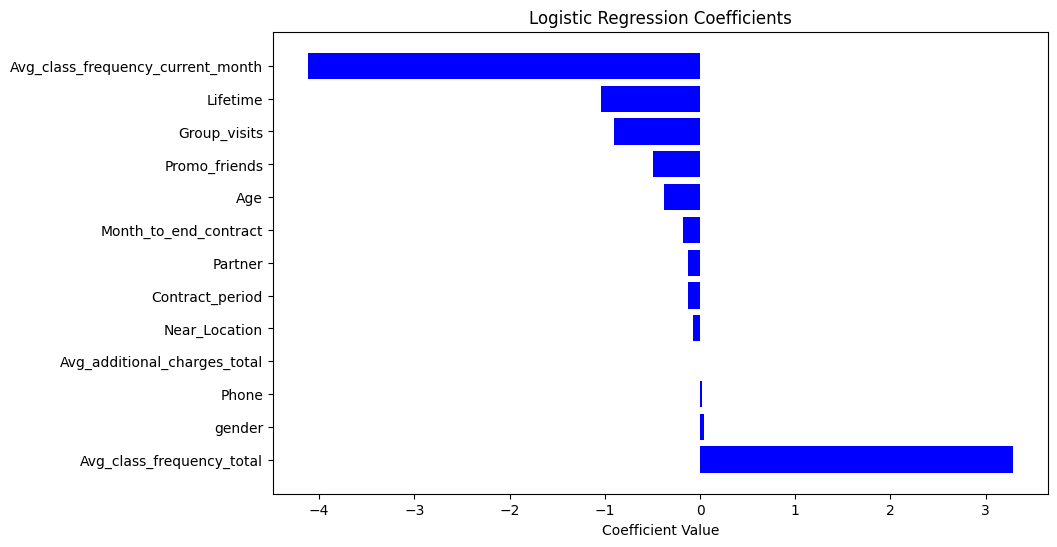

In [89]:
# Training the model
model = LogisticRegression(random_state=1, max_iter=1000)
model.fit(X_train, y_train)

# Getting the model coefficients
coef = model.coef_[0]
features = X.columns

# Creating a DataFrame to store the coefficients and features
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coef
})

coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Plotting the coefficients
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='blue')
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.show()

No código acima, plotamos os pesos das categorias para podermos identificar exatamente quais categorias impactam mais a probabilidade de cancelamento por parte dos clientes. O plot destaca principalmente a frequência média dos clientes no total e no mês atual, e também o Lifetime.

### Agrupando os clientes

In [79]:
# Standardizing the data
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

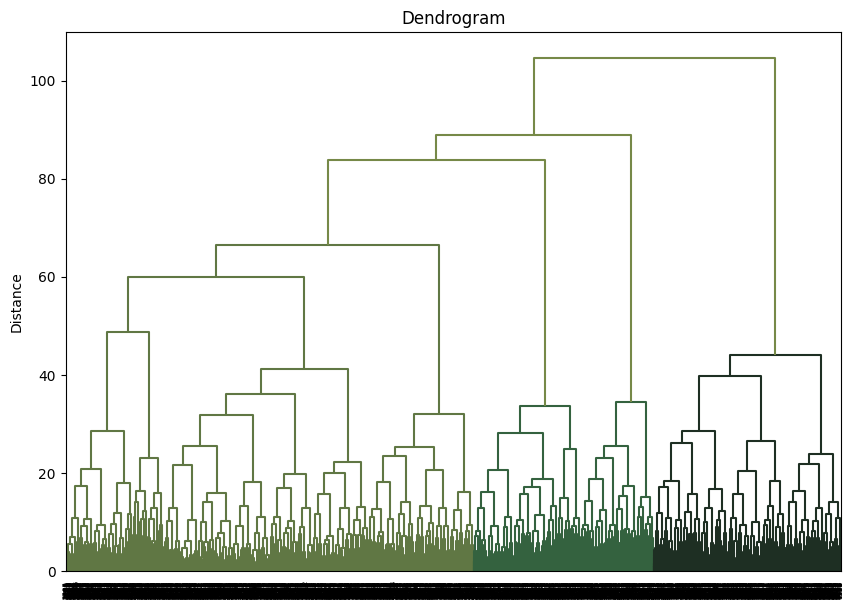

In [80]:
# Create the distance matrix
linked = sch.linkage(X_sc, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.ylabel('Distance')
plt.show()

Observando o dendograma acima, optamos por realizar um agrupamento em 5 grupos. O registro do grupo de cada lançamento será feito na nova coluna criada: Cluster.

In [81]:
# Define the number of clusters
n_clusters = 5

# Create the K-means model
kmeans = KMeans(n_clusters=n_clusters, random_state=1)

# Fit the model and predict clusters
clusters = kmeans.fit_predict(X_sc)

# Add the cluster column to the original DataFrame
df_churn['Cluster'] = clusters

In [82]:
# Grouping the data by the 'Cluster' column and calculating the mean of the features
df_churn.groupby('Cluster',as_index=False).mean()

,Cluster,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,0,0.567661,0.847477,0.276376,0.066514,1.0,2.674312,0.444954,30.020642,160.338090,2.475917,4.813073,2.786347,2.778736,0.083716
1,1,0.496000,0.948800,0.819200,0.998400,1.0,3.035200,0.440000,29.088000,141.247573,2.840000,3.728000,1.723431,1.616195,0.257600
2,2,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839
3,3,0.480384,0.722978,0.295436,0.013611,1.0,1.910328,0.276221,28.118495,129.750920,1.818255,2.204163,1.245948,0.992003,0.564452
4,4,0.500000,0.936636,0.740783,0.480415,1.0,11.827189,0.548387,29.896313,163.545056,10.785714,4.721198,2.001526,1.993737,0.021889


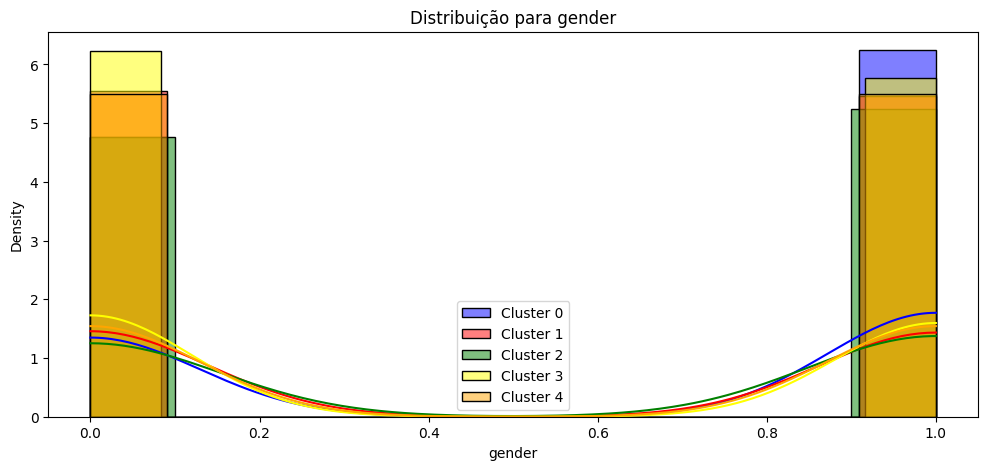

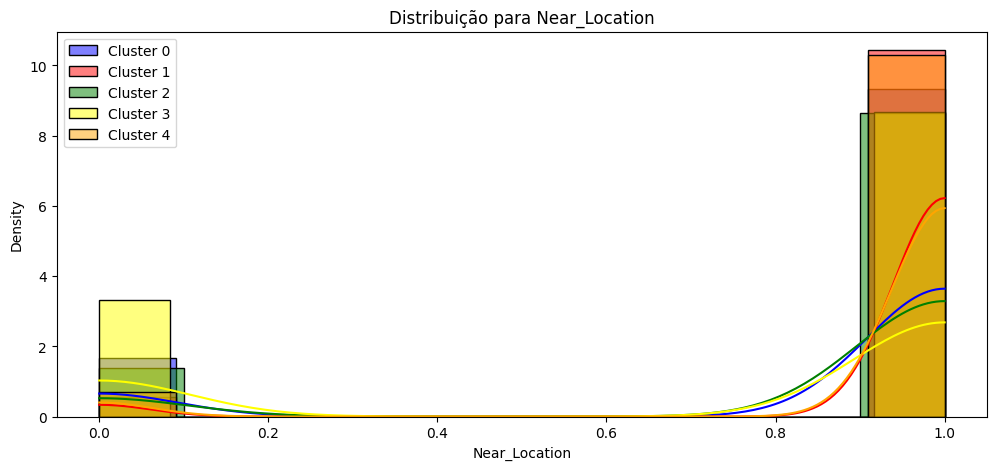

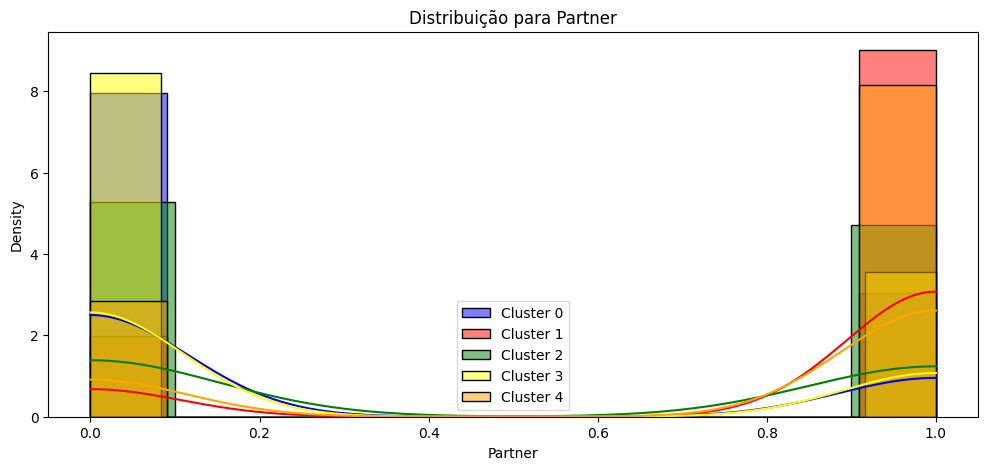

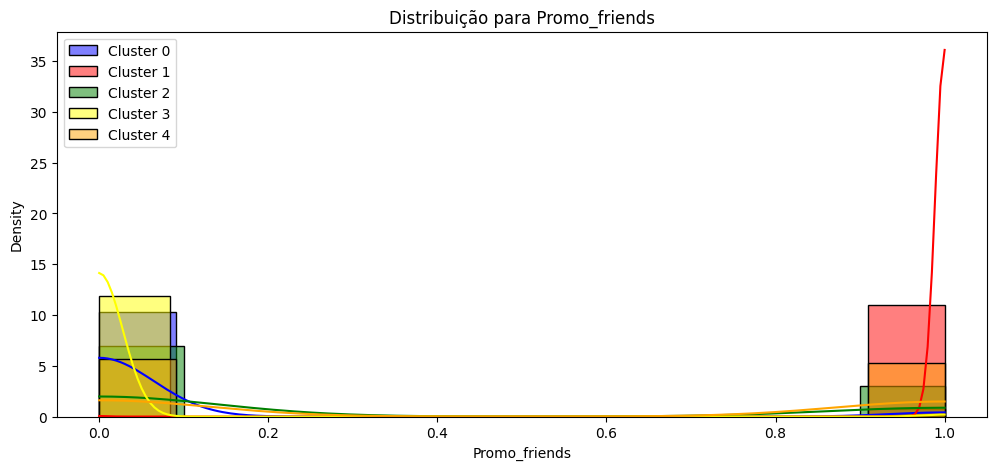

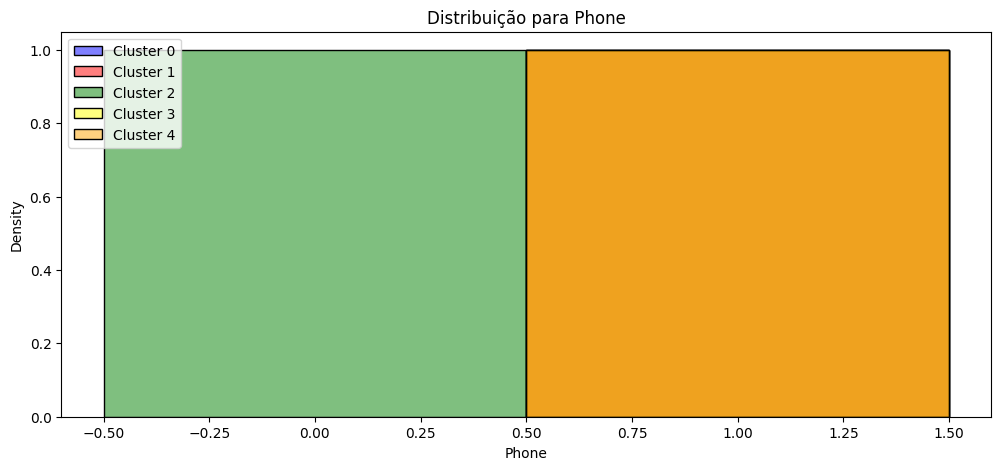

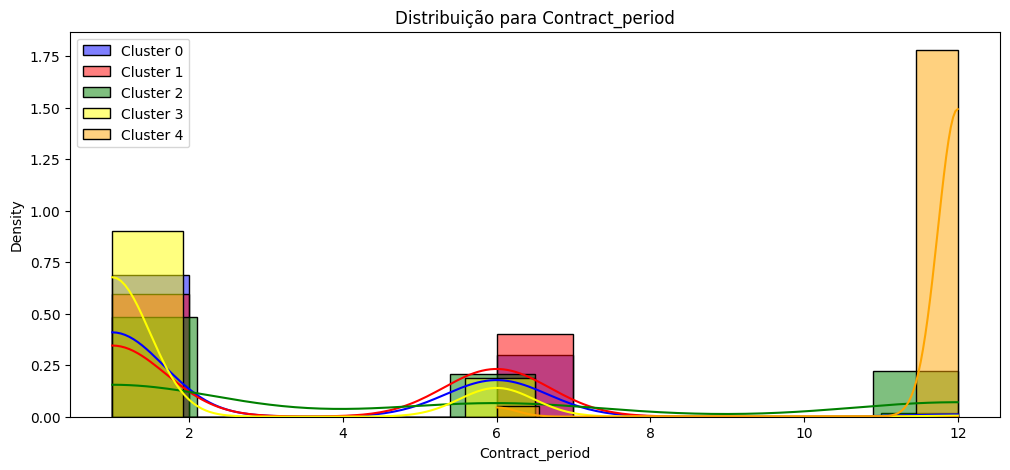

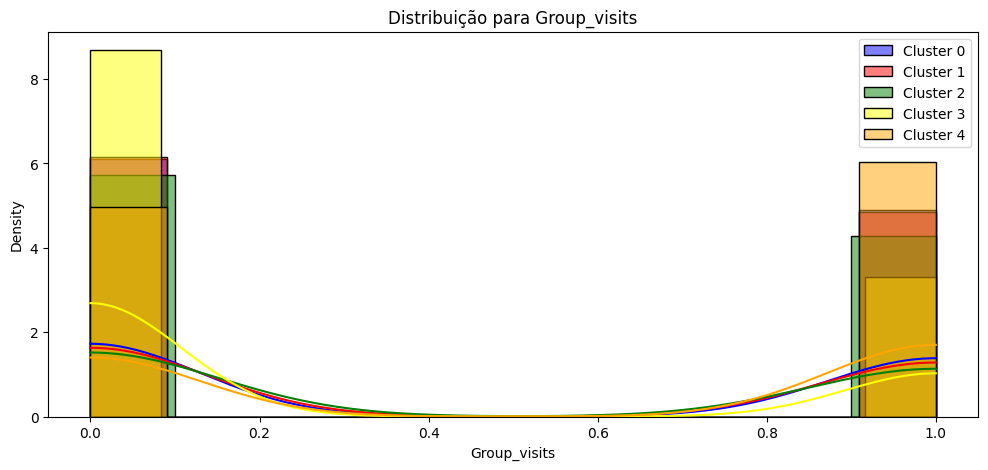

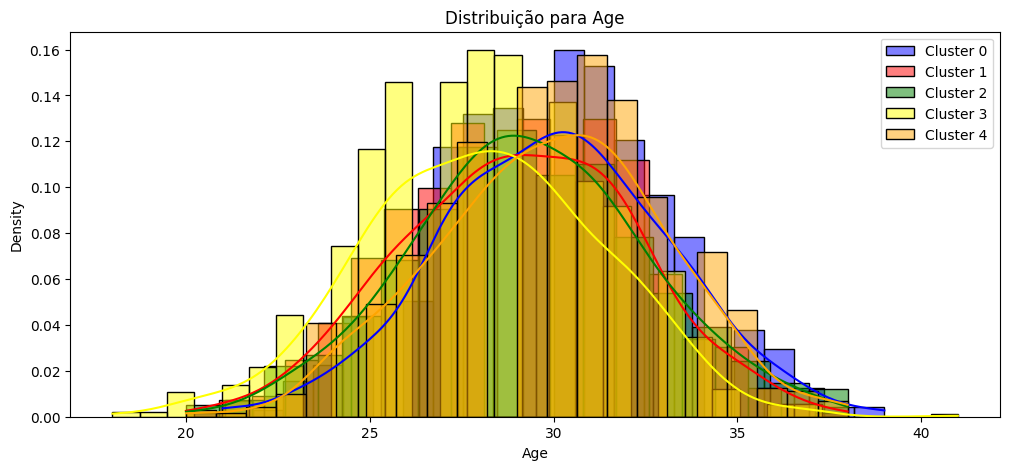

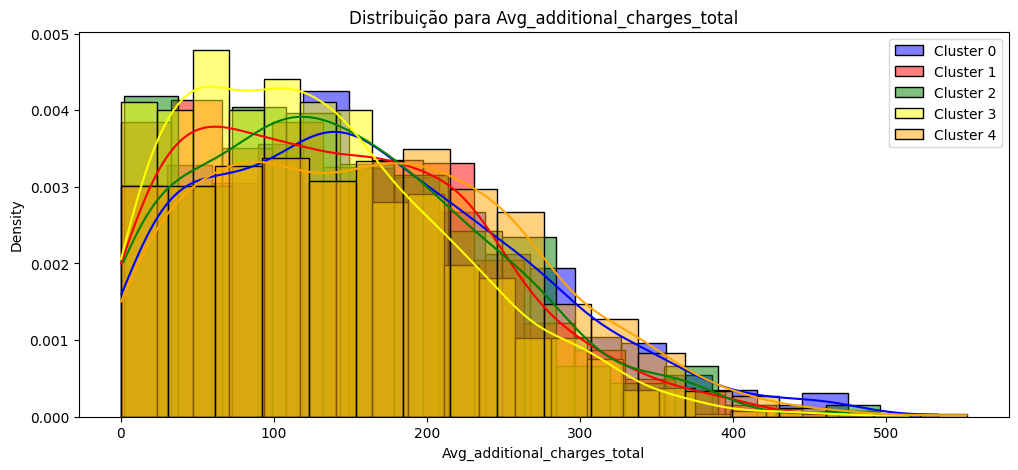

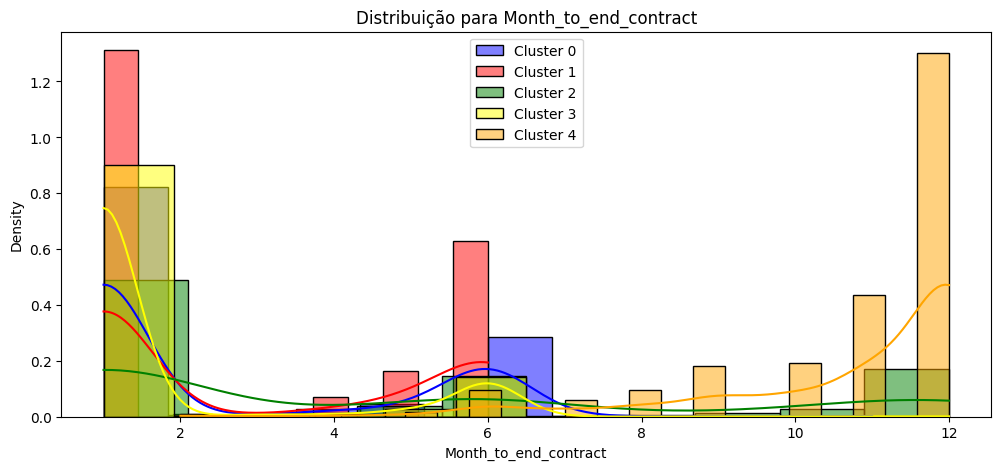

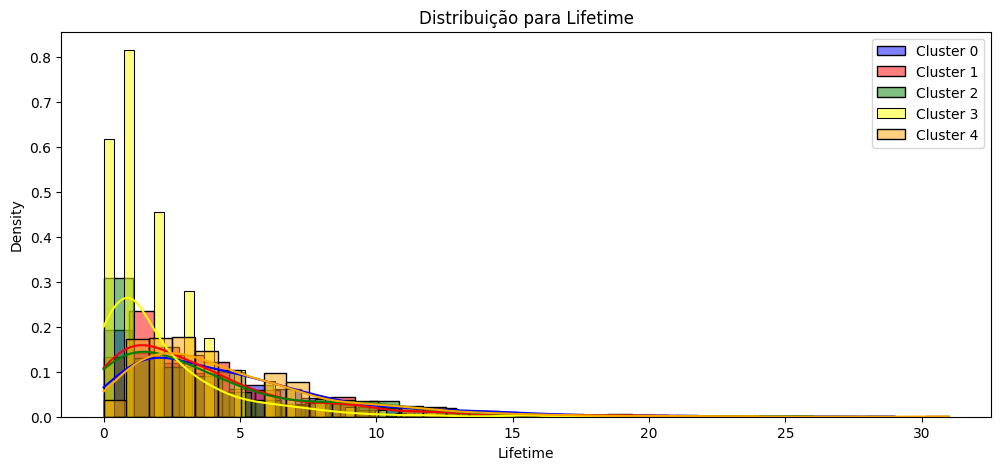

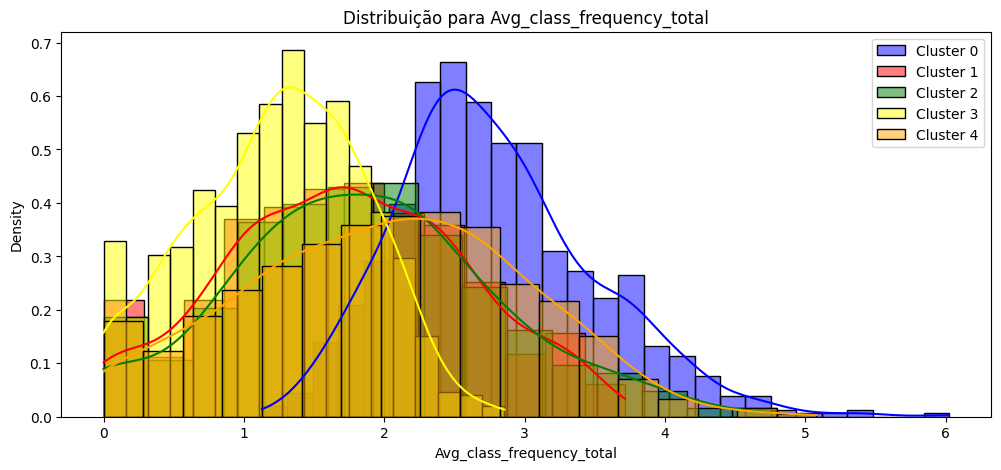

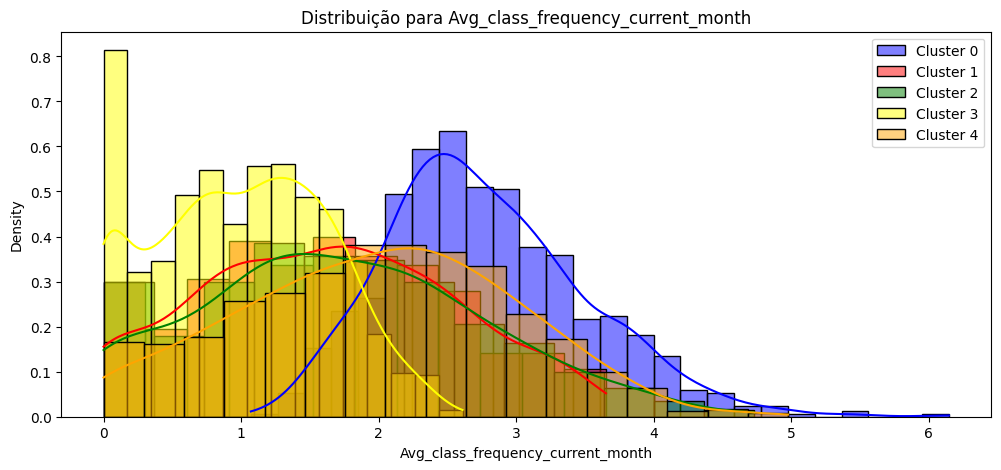

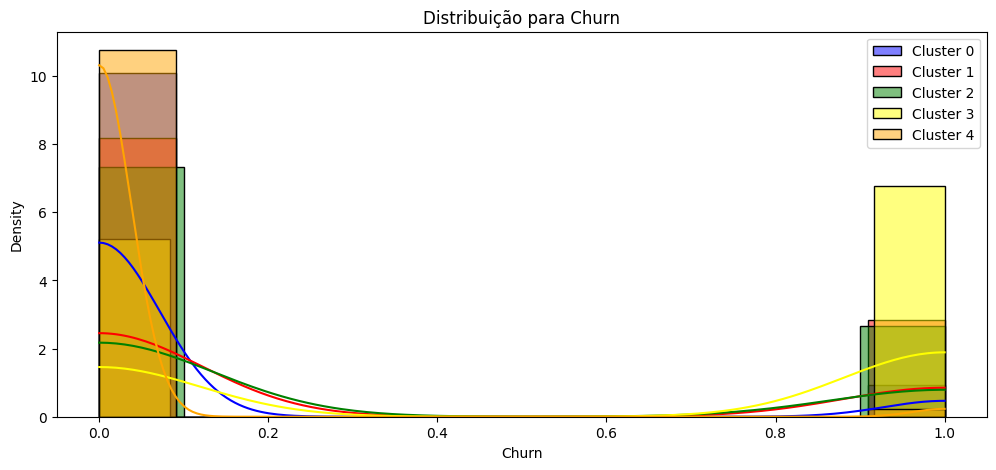

In [83]:
# Splitting the data
df_1 = df_churn[df_churn['Cluster']==0]
df_2 = df_churn[df_churn['Cluster']==1]
df_3 = df_churn[df_churn['Cluster']==2]
df_4 = df_churn[df_churn['Cluster']==3]
df_5 = df_churn[df_churn['Cluster']==4]

numerical_features = (df_churn.columns).drop('Cluster')

# Creating distributions for the features
for feature in numerical_features:
    plt.figure(figsize=(12, 5))
    sns.histplot(df_1[feature], kde=True, color='blue', label='Cluster 0', stat='density')
    sns.histplot(df_2[feature], kde=True, color='red', label='Cluster 1', stat='density')
    sns.histplot(df_3[feature], kde=True, color='green', label='Cluster 2', stat='density')
    sns.histplot(df_4[feature], kde=True, color='yellow', label='Cluster 3', stat='density')
    sns.histplot(df_5[feature], kde=True, color='orange', label='Cluster 4', stat='density')
    plt.title(f'Distribuição para {feature}')
    plt.legend()
    plt.show()

Observamos novamente algumas características que se destacam nos grupos 1, 2 e 3, que foram os grupos que obtiveram as piores taxas de cancelamento, e dentre essas características as que mais chamam a atenção estão relacionadas com a frequência que os clientes estão indo na academia: quando menos eles vão, mais chances de cancelarem. Podemos citar também o tempo que o cliente possui contrato, aqueles que fazem parte da academia a menos tempo também têm maiores probabilidades de cancelar o plano.

In [84]:
# Calculating churn rate for each cluster
churn_rate_by_cluster = df_churn.groupby('Cluster', as_index=False)['Churn'].mean()

# Print churn rate for each cluster
print("Churn Rate by Cluster:")
print(churn_rate_by_cluster)

Churn Rate by Cluster:
   Cluster     Churn
0        0  0.083716
1        1  0.257600
2        2  0.266839
3        3  0.564452
4        4  0.021889


### Conclusões Finais

De forma geral, podemos elencar algumas características que mais impactam a taxa de cancelamento e a partir disso propor recomendações e estratégias para a empresa investir em formas de reduzir essas taxas.  
  
Em primeiro lugar, seria ideal investir em campanhas de marketing que incentivem a musculação para os seus clientes, isso pode ser feito através de promoções de redução de preço, por certos períodos de tempo, para os clientes com baixa frequência nos últimos meses, aumentando a frequência deles e reduzindo a probabilidade de cancelamento.  
  
Além disso, é necessário criar alguma campanha de marketing que incentive a renovação do contrato, uma vez que essa é uma das características que também impactam no cancelamento. A equipe pode preparar promoções de renovação para fazer com que os clientes próximos ao fim do contrato renovem.

Por fim, ainda é possível utilizar o modelo escolhido para realizar buscas mensais sobre a probabilidade de cada cliente realizar o cancelamento do plano, podendo investir em métodos de prevenir o acontecimento, como o método de panfletagem, enviando incentivos para as pessoas se exercitarem e aumentar a vontade de frequentar a academia.